In [27]:
!pip install petrofit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [28]:
from astropy.nddata import CCDData, Cutout2D
from astropy.stats import sigma_clipped_stats
from astropy.table import Table
from petrofit.segmentation import make_catalog, plot_segments

import numpy as np
from matplotlib import pyplot as plt

In [29]:
#load FITS image data
image = CCDData.read('gal3.bz2')

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


In [30]:
#image flux unit
image.unit

Unit("nmgy")

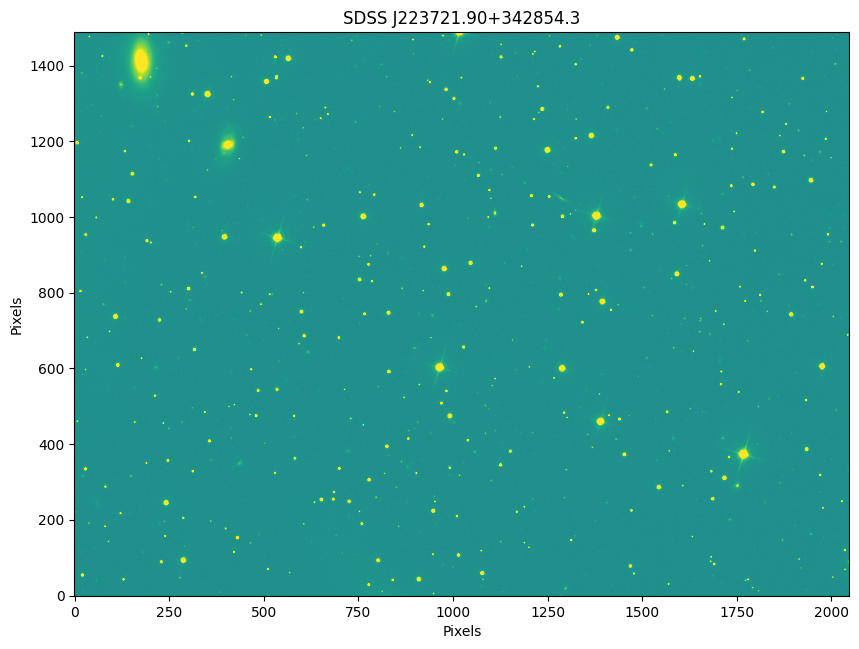

In [31]:
#plot the image
%matplotlib inline

plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['image.origin'] = 'lower'

vmax = image.data.std() # Use the image std as max and min range of all plots
vmin = - vmax

plt.imshow(image.data, vmin=vmin, vmax=vmax)
plt.title("SDSS J223721.90+342854.3")
plt.xlabel("Pixels")
plt.ylabel("Pixels")
plt.show()

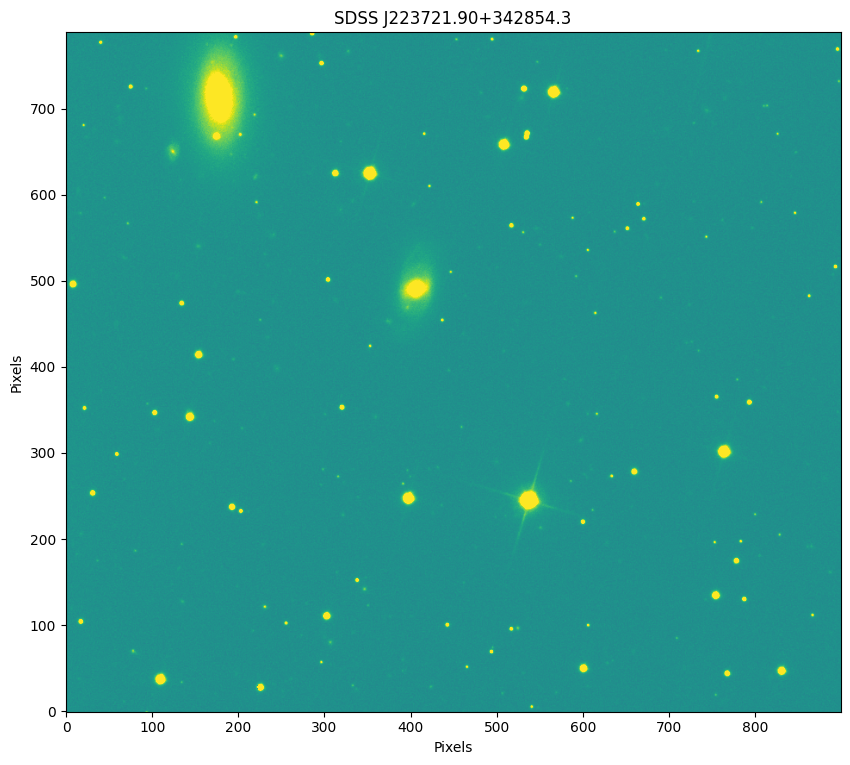

In [32]:
#plot zoom-in/cutout version of image
cutout_image = Cutout2D(image, position=(400,1200), size=1000)

plt.imshow(cutout_image.data, vmin=vmin, vmax=vmax)
plt.title("SDSS J223721.90+342854.3")
plt.xlabel("Pixels")
plt.ylabel("Pixels")
plt.show()

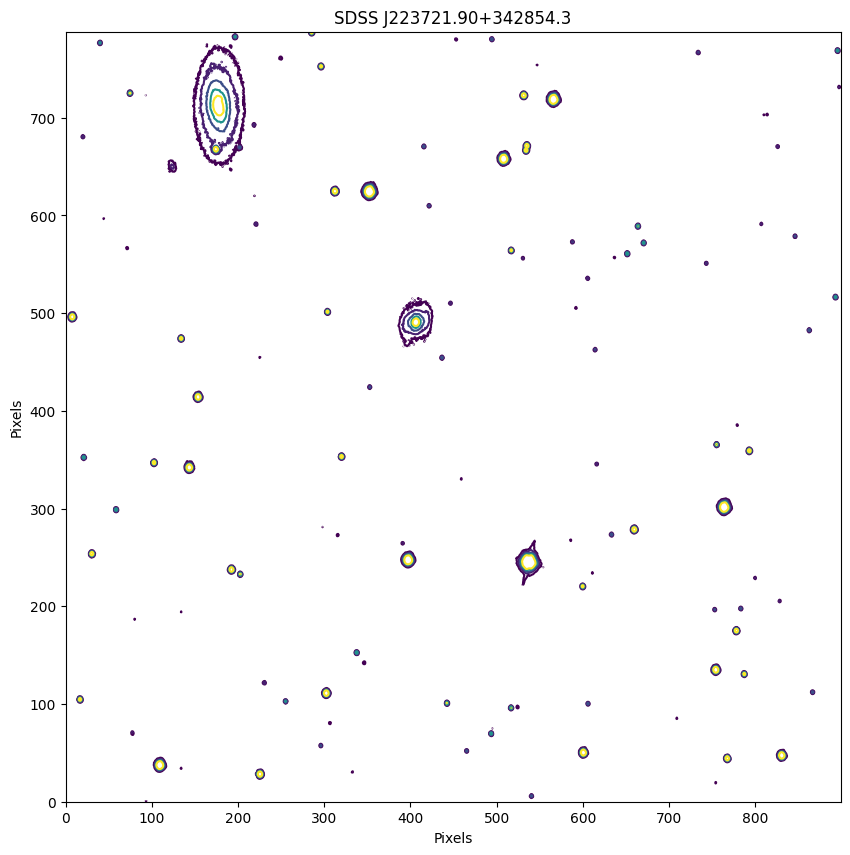

In [33]:
#plot image intensity contour
ax = plt.subplot()
ax.contour(cutout_image.data, levels=np.logspace(-0.5, 0.5, 5))#, colors='white', alpha=0.5)

plt.title("SDSS J223721.90+342854.3")
plt.xlabel("Pixels")
plt.ylabel("Pixels")
plt.show()

0.006980574 0.1489563211798668 0.3972168564796448


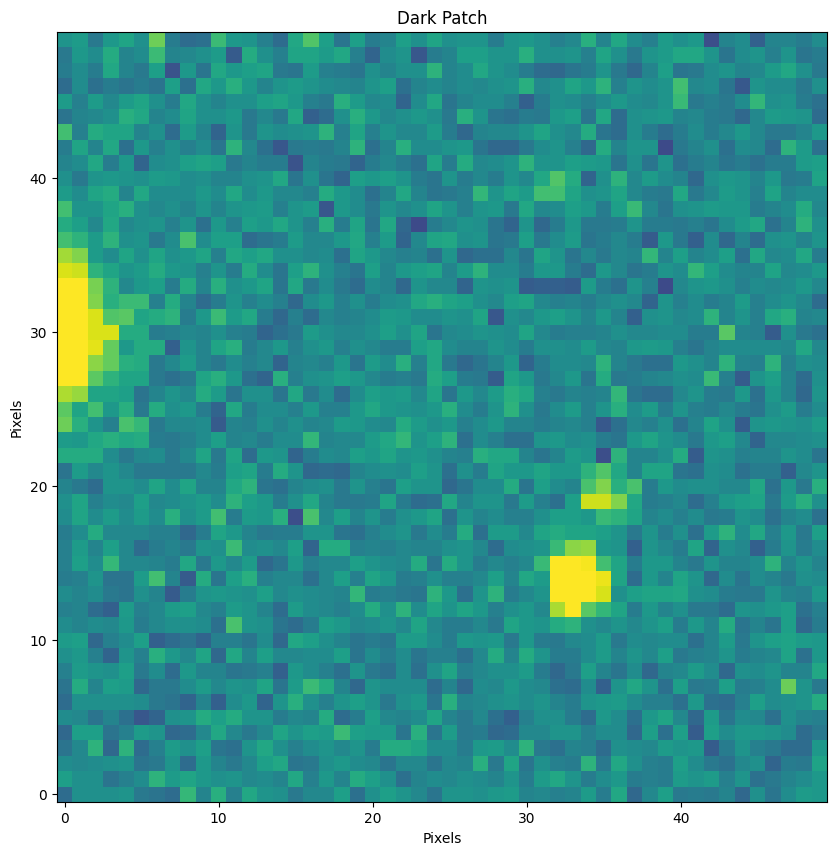

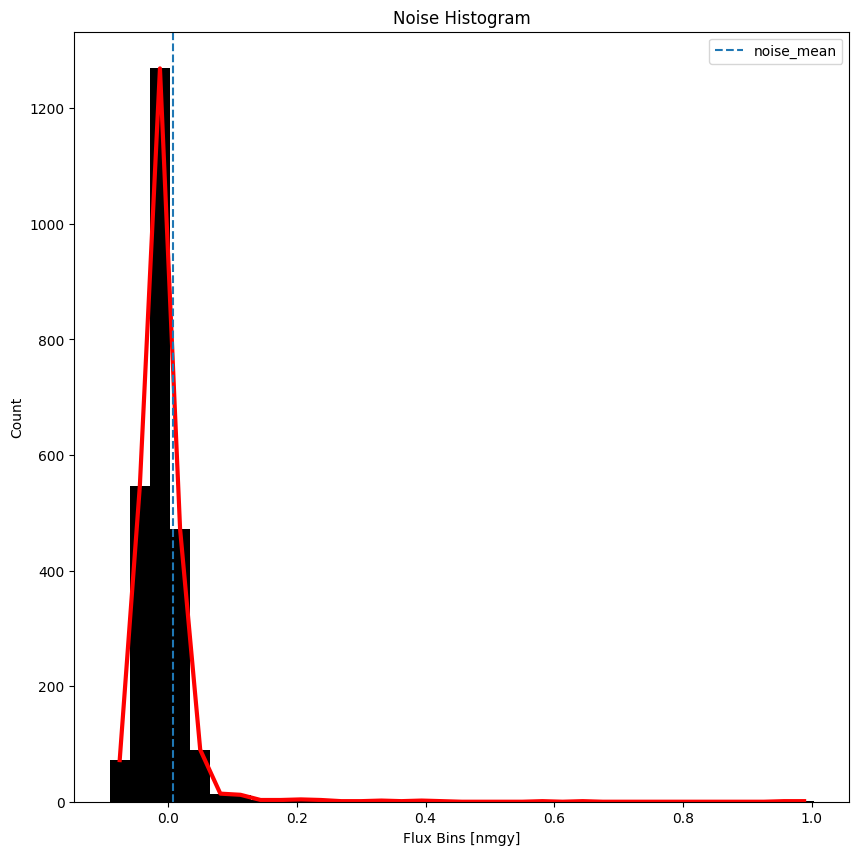

In [34]:
#estimate data noise at dark area
noise_cutout_pos = (50, 50)
noise_cutout_size = 50
noise_cutout = Cutout2D(image, noise_cutout_pos, noise_cutout_size)

noise_mean = noise_cutout.data.mean()
noise_sigma = noise_cutout.data.std()
noise_1_sigma = noise_sigma * 1.
noise_3_sigma = noise_sigma * 3.
noise_8_sigma = noise_sigma * 8.

print(noise_mean, noise_3_sigma, noise_8_sigma)

#plot image and noise distribution
plt.imshow(noise_cutout.data, vmax=noise_mean+noise_3_sigma, vmin=noise_mean-noise_3_sigma)
plt.title("Dark Patch")
plt.xlabel("Pixels")
plt.ylabel("Pixels")
plt.show()

n, bins, patches = plt.hist(noise_cutout.data.flatten(), bins=35, align='left', color='black')
plt.plot(bins[:-1], n, c='r', linewidth=3)
plt.axvline(noise_mean, label="noise_mean", linestyle="--")

plt.xlabel('Flux Bins [{}]'.format(str(image.unit)))
plt.ylabel('Count')
plt.title('Noise Histogram')
plt.legend()

plt.show()

In [35]:
image_mean, image_median, image_stddev = sigma_clipped_stats(image.data, sigma=3)

In [36]:
#define detect threshold
threshold = noise_3_sigma

kernel_size = 7
fwhm = 3

In [37]:
npixels = int(np.floor(12.2**2))

Deblending:   0%|          | 0/18 [00:00<?, ?it/s]

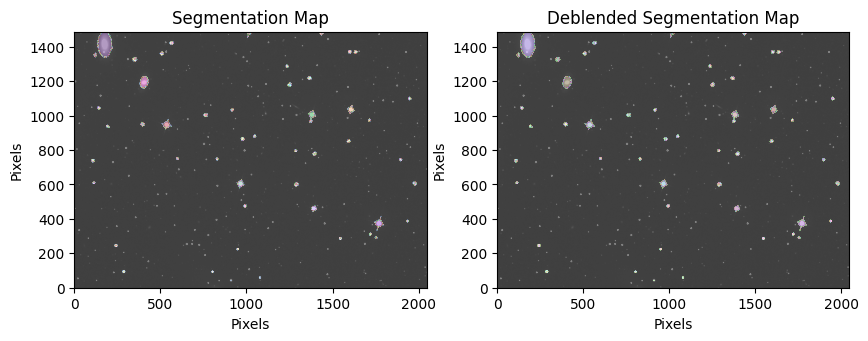

In [38]:
#plot segmentation and deblended segmentation map
cat, segm, segm_deblend = make_catalog(
    image.data,
    threshold,
    deblend=True,
    kernel_size=kernel_size,
    fwhm=fwhm,
    npixels=npixels,
    plot=True, vmax=vmax, vmin=vmin
)

In [39]:
#display source properties
print("Num of Targets:", len(cat))

#convert to table
cat_table = cat.to_table()

cat_table[:10]

Num of Targets: 50


<QTable length=10>
label     xcentroid          ycentroid      ...     kron_flux      kron_fluxerr
                                            ...                                
int64      float64            float64       ...      float64         float64   
----- ------------------ ------------------ ... ------------------ ------------
    1  910.8029564107301   43.9851116959832 ... 1039.0292116282753          nan
    2 1078.3190929959983 60.136024072571416 ...  685.9938404944606          nan
    3 288.42662757994174  94.22862828837467 ... 1073.6542989212915          nan
    4  803.2982044600145   93.8690989558792 ...  525.4783425651242          nan
    5  948.8982520434527 224.63013927211284 ...  609.7698912466901          nan
    6 242.83030186465484 245.74299901352322 ...  1210.311509635304          nan
    7 1545.0279997001644 286.85320330708413 ...  990.9823225845931          nan
    8 1752.4069436092147  291.1078134273507 ...  96.14290290579967          nan
    9 1718.3935360453386 311.55141152054466 ...  928.0672864084687          nan
   10   1768.43821516107  373.7161936363954 ...   3349.48498932466          nan

Text(0, 0.5, 'Pixels')

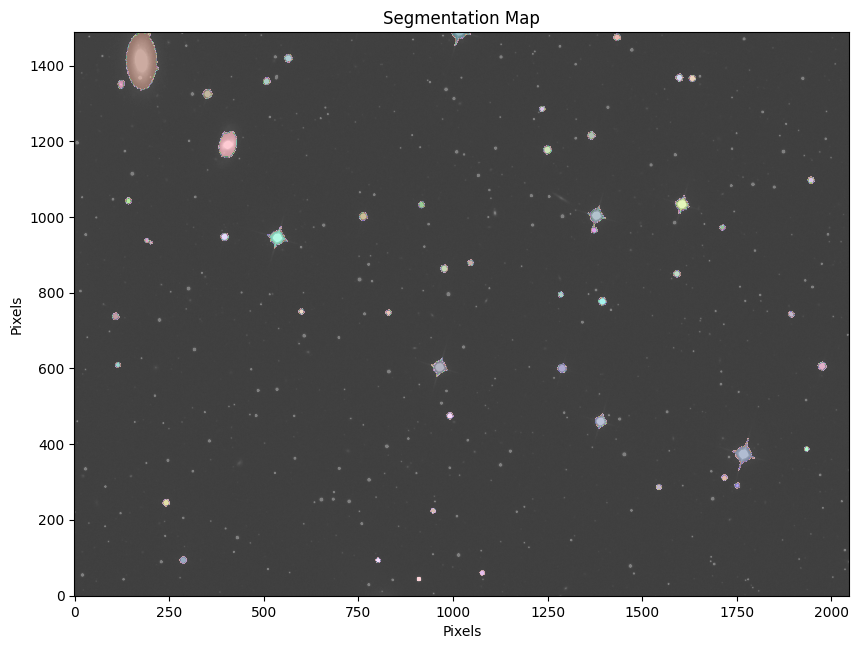

In [40]:
#plot segmentation map
plot_segments(segm, image=image.data, vmax=vmax, vmin=vmin)

plt.title("Segmentation Map")
plt.xlabel("Pixels")
plt.ylabel("Pixels")

Text(0, 0.5, 'Pixels')

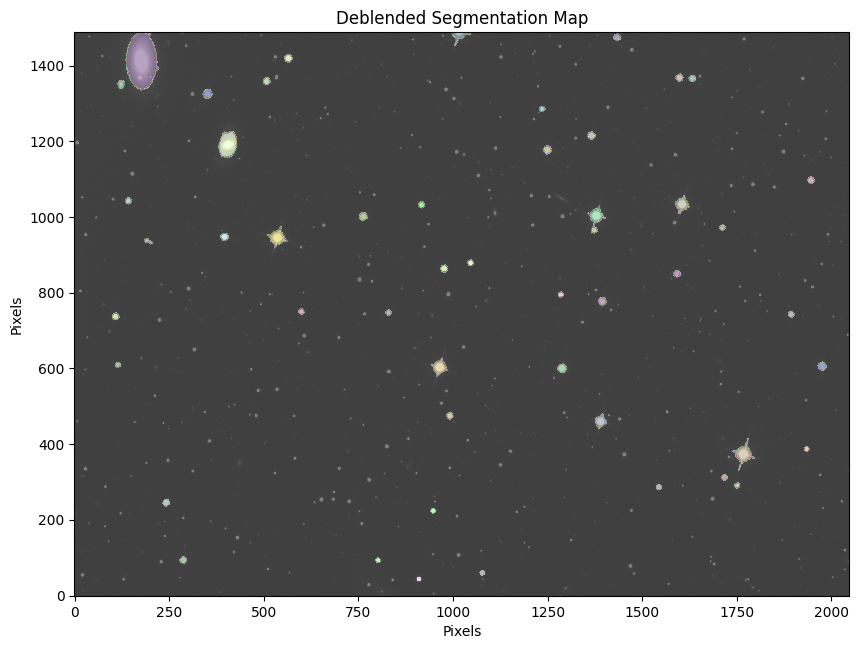

In [41]:
#plot deblended segmentation map
plot_segments(segm_deblend, image=image.data, vmax=vmax, vmin=vmin)

plt.title("Deblended Segmentation Map")
plt.xlabel("Pixels")
plt.ylabel("Pixels")

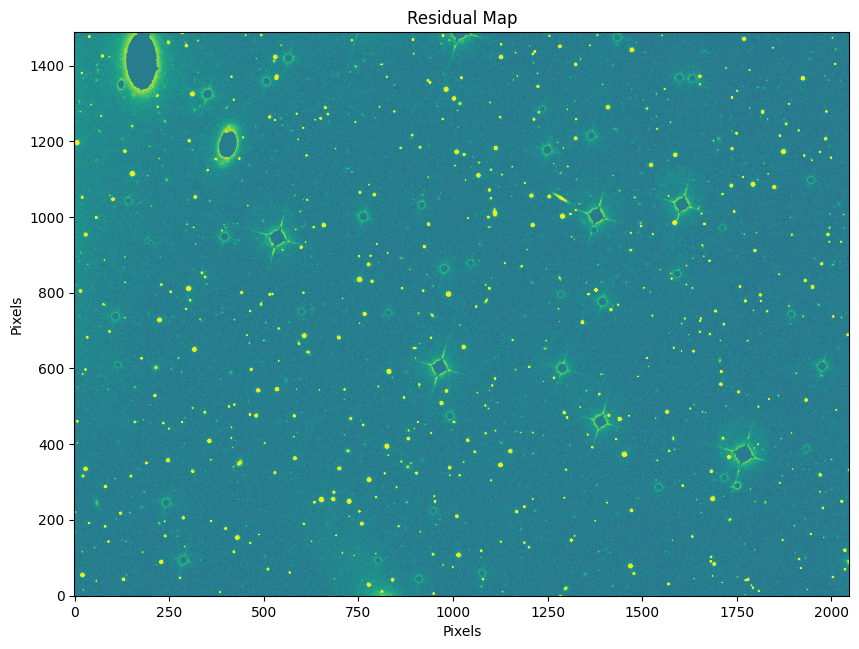

In [42]:
#plot residual
from petrofit.segmentation import plot_segment_residual
plot_segment_residual(segm, image.data, vmax=vmax/5)

plt.title("Residual Map")
plt.xlabel("Pixels")
plt.ylabel("Pixels")
plt.show()

In [43]:
from petrofit.photometry import order_cat

#sort and get the largest object in the catalog
sorted_idx_list = order_cat(cat, key='area', reverse=True)
idx = sorted_idx_list[1] #index 0 is largest
source = cat[idx]  #get souce from the catalog

In [44]:
from petrofit.photometry import make_radius_list

r_list = make_radius_list(
    max_pix=200, #max pixel to go up to
    n=50 #he number of radii to produce
)

print(repr(r_list))

array([  4.,   8.,  12.,  16.,  20.,  24.,  28.,  32.,  36.,  40.,  44.,
        48.,  52.,  56.,  60.,  64.,  68.,  72.,  76.,  80.,  84.,  88.,
        92.,  96., 100., 104., 108., 112., 116., 120., 124., 128., 132.,
       136., 140., 144., 148., 152., 156., 160., 164., 168., 172., 176.,
       180., 184., 188., 192., 196., 200.])


38


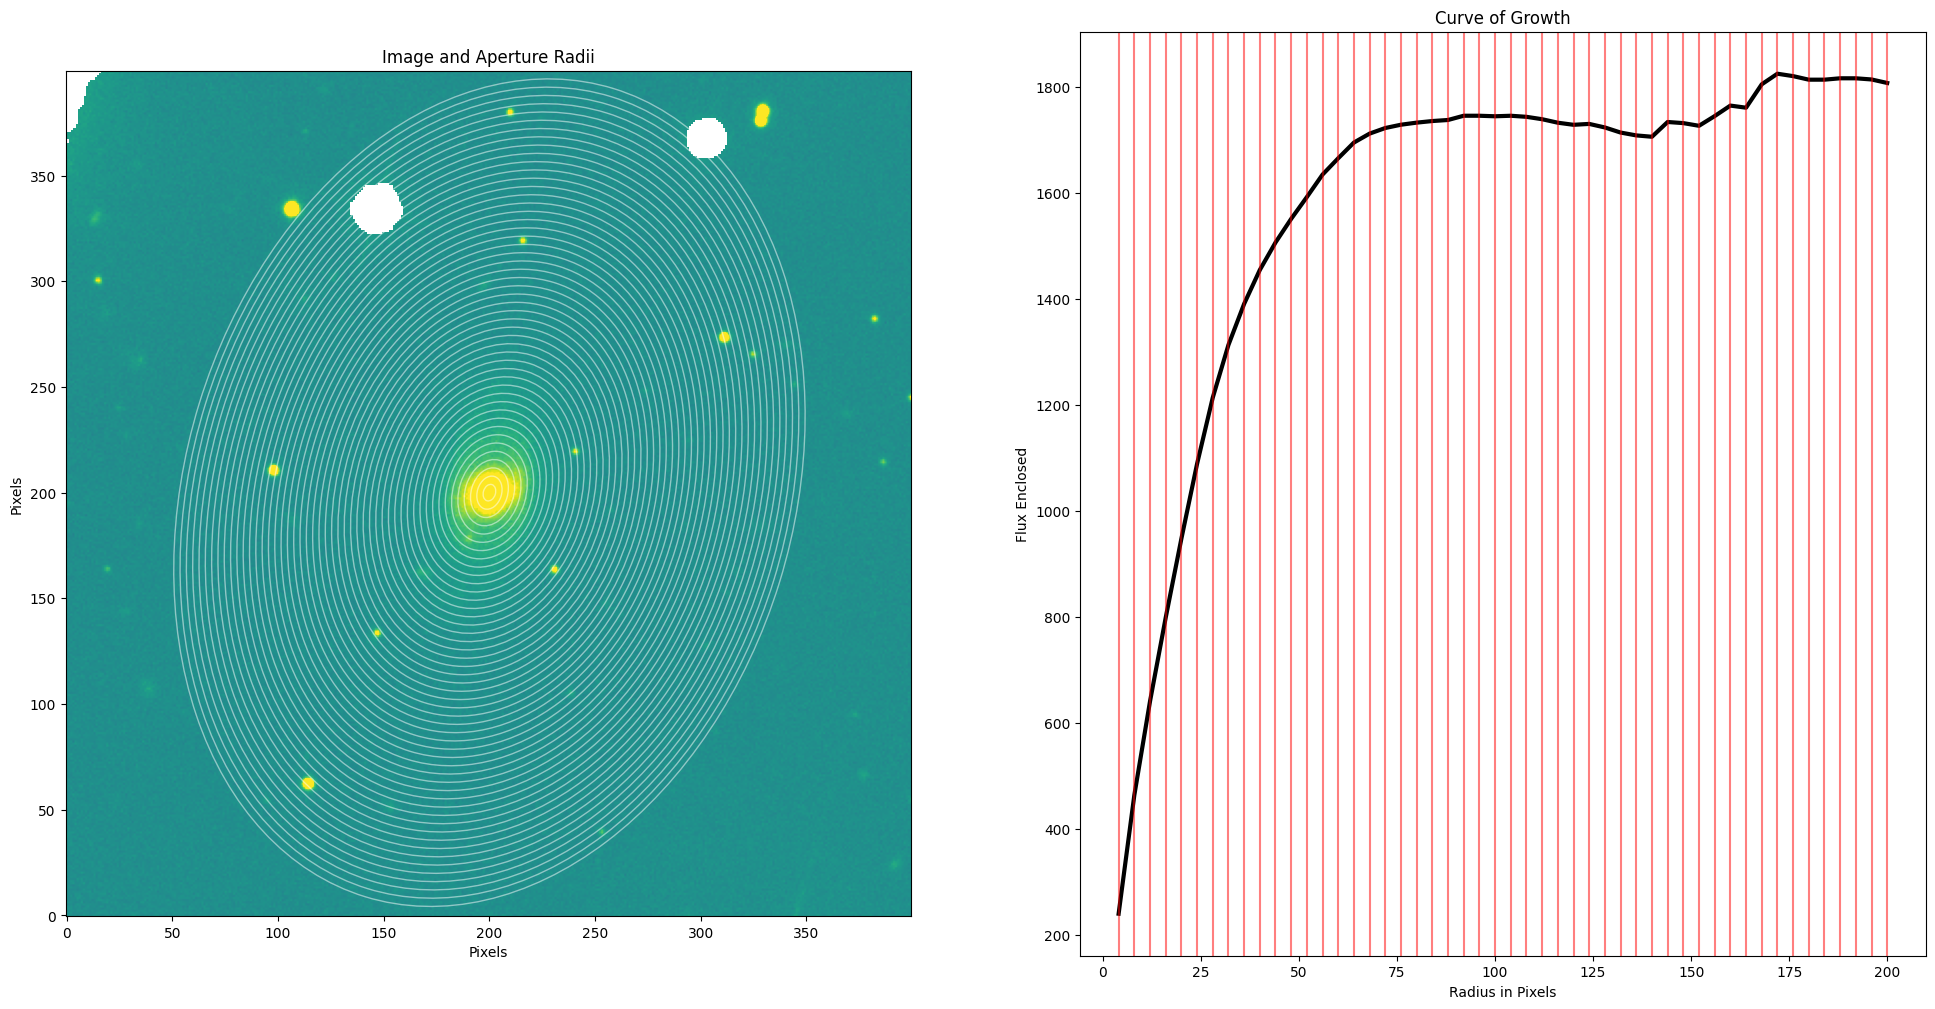

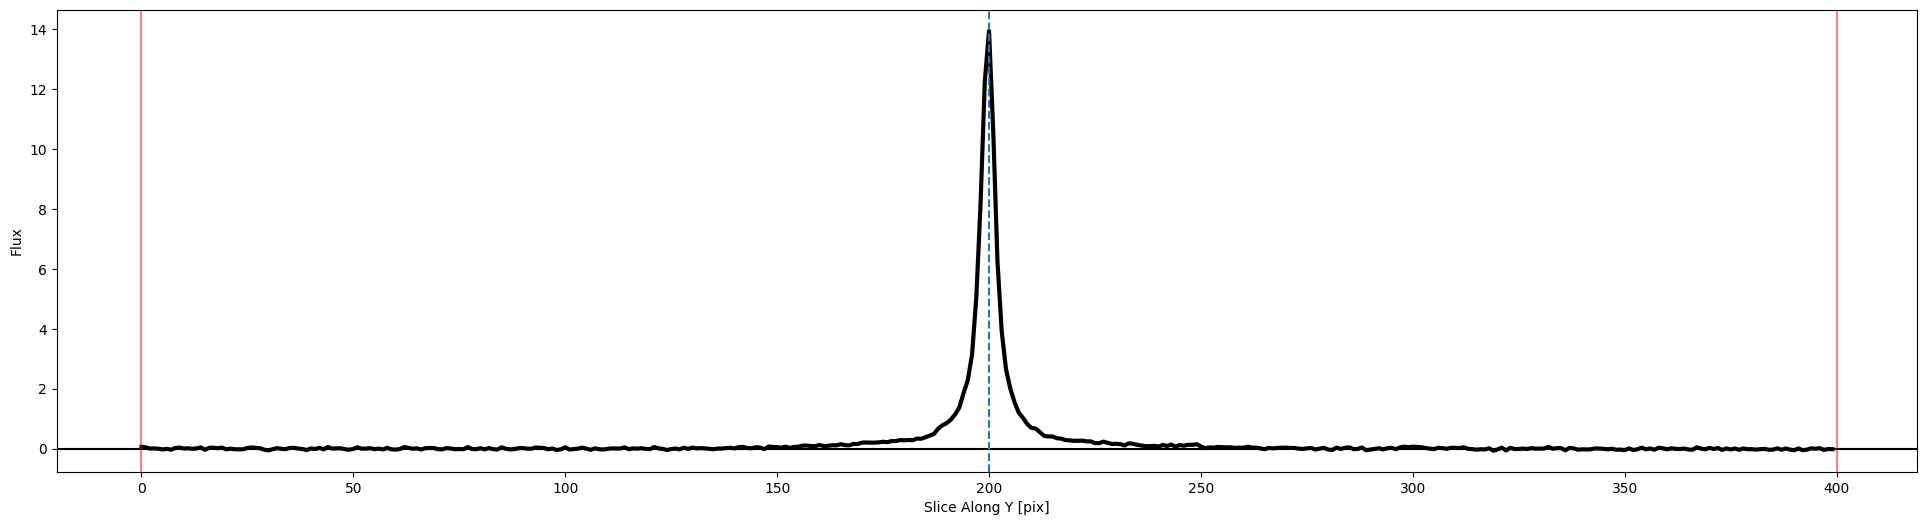

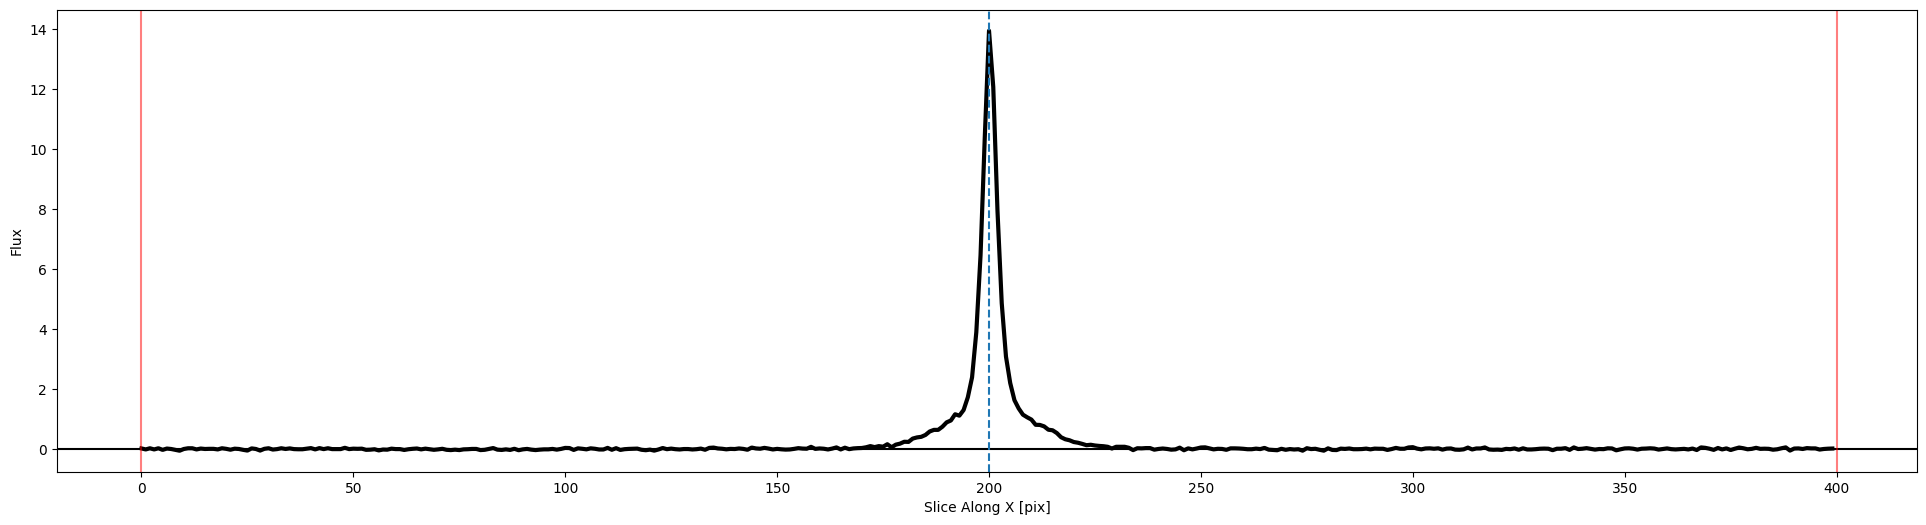

In [45]:
from petrofit.photometry import source_photometry

#photometry
flux_arr, area_arr, error_arr = source_photometry(

    #inputs
    source, #source (`photutils.segmentation.catalog.SourceCatalog`)
    image.data, #image as 2D array
    segm_deblend, #deblended segmentation map of image
    r_list, #list of aperture radii

    #options
    cutout_size=2*max(r_list), #cutout size, set to double the max radius
    bkg_sub=True, #subtract background
    sigma=3, sigma_type='clip', #fit a 2D plane to pixels within 3 sigma of the mean
    plot=True, vmax=vmax, vmin=vmin, #show plot with max and min defined above
)
plt.show()

In [47]:
#list photometry data in a table
t = Table(
    data=[r_list, flux_arr, area_arr, error_arr],
    names=['r_list', 'flux_arr', 'area_arr', 'error_arr'],
)

t.write('phot_galaxy.csv', overwrite=True)

t[:10]

<Table length=10>
 r_list   flux_arr    area_arr  error_arr
float64   float64     float64    float64 
------- ----------- ----------- ---------
    4.0  239.673602   36.098916       nan
    8.0  463.315138  144.395666       nan
   12.0  640.396398  324.890248       nan
   16.0  798.378831  577.582663       nan
   20.0   947.47833  902.472911       nan
   24.0 1088.744091 1299.560992       nan
   28.0 1213.769104 1768.846906       nan
   32.0 1313.285242 2310.330652       nan
   36.0 1390.792065 2924.012232       nan
   40.0 1454.801491 3609.891644       nan

In [48]:
#calculate petrosian function
from petrofit.petrosian import Petrosian

p = Petrosian(r_list, area_arr, flux_arr)

In [49]:
#calculate petrosian radius in pixels
p.r_petrosian

43.76875375075015

In [50]:
#calculate total flux
p.total_flux 

1737.3723771729924

In [51]:
#calculate petrosian magnitude
mag = 22.5 - 2.5*np.log10(p.total_flux)
mag

14.400267719254987

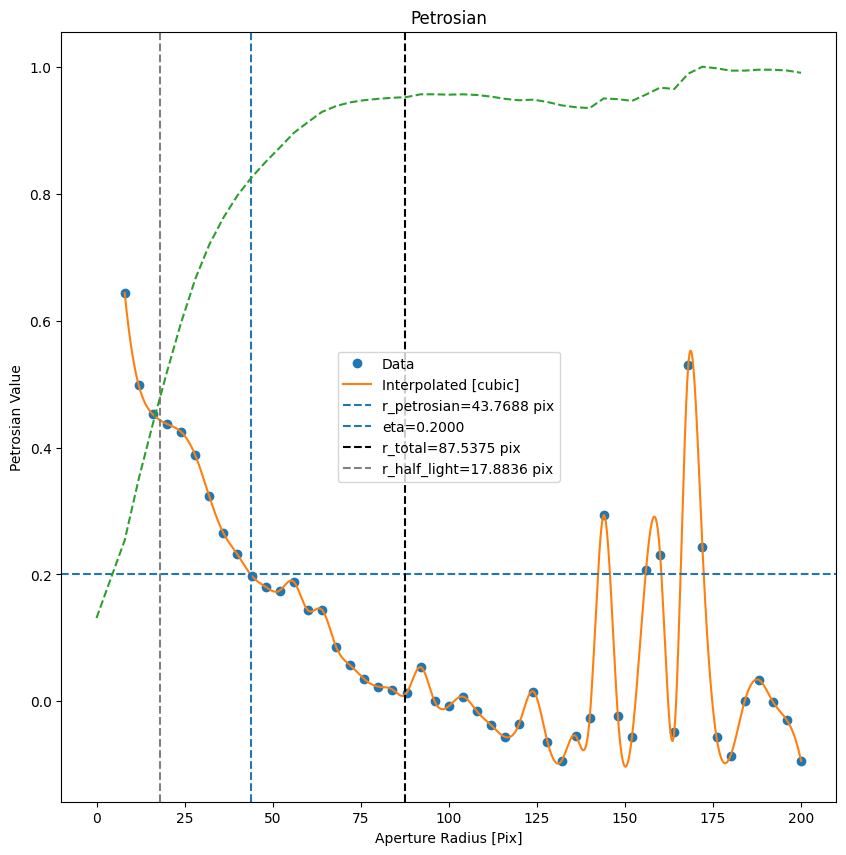

In [52]:
#plot the results
p.plot(plot_r=True, plot_normalized_flux=True)
plt.show()

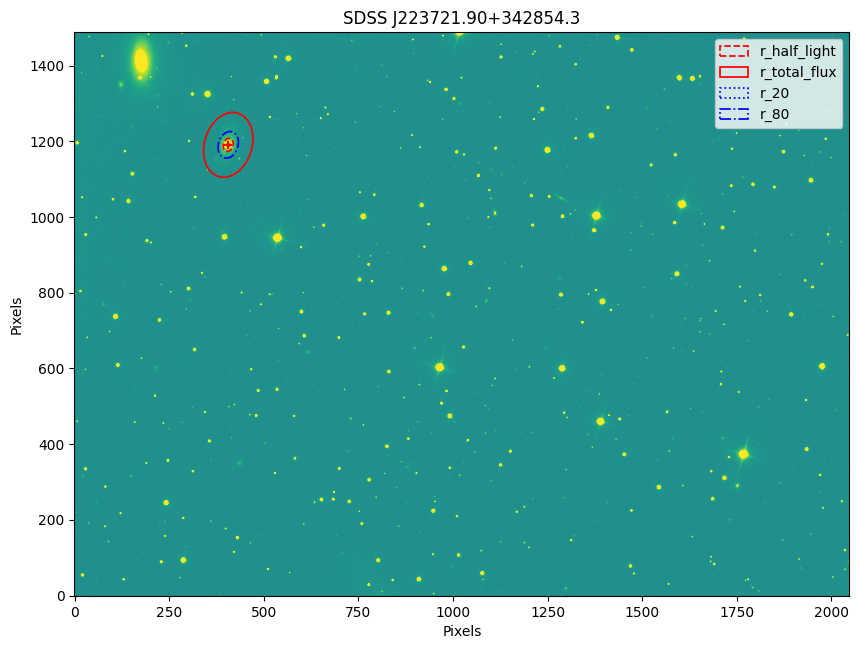

In [53]:
#plot the source
from petrofit.segmentation import get_source_position, get_source_elong, get_source_theta

position = get_source_position(source)
elong = get_source_elong(source)
theta = get_source_theta(source)

p.imshow(position=position, elong=elong, theta=theta, lw=1.25)

plt.imshow(image.data, vmax=vmax, vmin=vmin)

plt.legend()
plt.title("SDSS J223721.90+342854.3")
plt.xlabel("Pixels")
plt.ylabel("Pixels")
plt.show()